### Training RL Policies using L5Kit Closed-Loop Environment

This notebook describes how to train RL policies for self-driving using our gym-compatible closed-loop environment.

We will be using [Proximal Policy Optimization (PPO)](https://arxiv.org/abs/1707.06347) algorithm as our reinforcement learning algorithm, as it not only demonstrates remarkable performance but it is also empirically easy to tune.

The PPO implementation in this notebook is based on [Stable Baselines3](https://github.com/DLR-RM/stable-baselines3) framework, a popular framework for training RL policies. Note that our environment is also compatible with [RLlib](https://docs.ray.io/en/latest/rllib.html), another popular frameworks for the same.

In [1]:
import os
os.environ["L5KIT_DATA_FOLDER"] = '/workspace/datasets'
os.environ['CUDA_VISIBLE_DEVICES']= '0'

In [2]:
# #@title Download L5 Sample Dataset and install L5Kit
# import os
# RunningInCOLAB = 'google.colab' in str(get_ipython())
# if RunningInCOLAB:
#     !wget https://raw.githubusercontent.com/lyft/l5kit/master/examples/setup_notebook_colab.sh -q
#     !sh ./setup_notebook_colab.sh
#     os.environ["L5KIT_DATA_FOLDER"] = open("./dataset_dir.txt", "r").read().strip()
# else:
#     os.environ["L5KIT_DATA_FOLDER"] = "/tmp/level5_data"
#     print("Not running in Google Colab.")

In [3]:
import gym

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import get_linear_fn
from stable_baselines3.common.vec_env import SubprocVecEnv

from l5kit.configs import load_config_data
from l5kit.environment.feature_extractor import CustomFeatureExtractor
from l5kit.environment.callbacks import L5KitEvalCallback
from l5kit.environment.envs.l5_env import SimulationConfigGym

from l5kit.visualization.visualizer.zarr_utils import episode_out_to_visualizer_scene_gym_cle
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from prettytable import PrettyTable
import datetime
import pytz

In [4]:
# Dataset is assumed to be on the folder specified
# in the L5KIT_DATA_FOLDER environment variable

# get environment config
env_config_path = '/workspace/source/configs/gym_config.yaml'
cfg = load_config_data(env_config_path)

### Define Training and Evaluation Environments

**Training**: We will be training the PPO policy on episodes of length 32 time-steps. We will have 4 sub-processes (training environments) that will help to parallelize and speeden up episode rollouts. The *SimConfig* dataclass will define the parameters of the episode rollout: like length of episode rollout, whether to use log-replayed agents or simulated agents etc.

**Evaluation**: We will evaluate the performance of the PPO policy on the *entire* scene (~248 time-steps).

In [5]:
# Train on episodes of length 32 time steps
train_eps_length = 32
train_envs = 4

# Evaluate on entire scene (~248 time steps)
eval_eps_length = None
eval_envs = 1

# make train env
train_sim_cfg = SimulationConfigGym()
train_sim_cfg.num_simulation_steps = train_eps_length + 1
env_kwargs = {'env_config_path': env_config_path, 'use_kinematic': True, 'sim_cfg': train_sim_cfg}
env = make_vec_env("L5-CLE-v0", env_kwargs=env_kwargs, n_envs=train_envs,
                   vec_env_cls=SubprocVecEnv, vec_env_kwargs={"start_method": "fork"})

# make eval env
validation_sim_cfg = SimulationConfigGym()
validation_sim_cfg.num_simulation_steps = None
eval_env_kwargs = {'env_config_path': env_config_path, 'use_kinematic': True, \
                   'return_info': True, 'train': False, 'sim_cfg': validation_sim_cfg}
eval_env = make_vec_env("L5-CLE-v0", env_kwargs=eval_env_kwargs, n_envs=eval_envs,
                        vec_env_cls=SubprocVecEnv, vec_env_kwargs={"start_method": "fork"})

/workspace/source/l5kit_original1/l5kit/l5kit/data/zarr_dataset.py:213: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  dataset = ChunkedDataset("")
/workspace/source/l5kit_original1/l5kit/l5kit/data/zarr_dataset.py:213: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  dataset = ChunkedDataset("")
/workspace/source/l5kit_original1/l5kit/l5kit/simulation/utils.py:107: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  new_dataset = ChunkedDataset("")
/workspace/source/l5kit_original1/l5kit/l5kit/data/zarr_dataset.py:213: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  dataset = ChunkedDataset("")
/workspace/source/l5kit_original1/l5kit/l5kit/data/zarr_dataset.py:213: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  dataset = C

### Define backbone feature extractor

The backbone feature extractor is shared between the policy and the value networks. The feature extractor *simple_gn* is composed of two convolutional networks followed by a fully connected layer, with ReLU activation. The feature extractor output is passed to both the policy and value networks composed of two fully connected layers with tanh activation (SB3 default).

We perform **group normalization** after every convolutional layer. Empirically, we found that group normalization performs far superior to batch normalization. This can be attributed to the fact that activation statistics change quickly in on-policy algorithms (PPO is on-policy) while batch-norm learnable parameters can be slow to update causing training issues.

In [6]:
# A simple 2 Layer CNN architecture with group normalization
model_arch = 'simple_gn'
features_dim = 128

# Custom Feature Extractor backbone
policy_kwargs = {
    "features_extractor_class": CustomFeatureExtractor,
    "features_extractor_kwargs": {"features_dim": features_dim, "model_arch": model_arch},
    "normalize_images": False
}

### Clipping Schedule

We linearly decrease the value of the clipping parameter $\epsilon$ as the PPO training progress as it shows improved training stability

In [7]:
# Clipping schedule of PPO epsilon parameter
start_val = 0.1
end_val = 0.01
training_progress_ratio = 1.0
clip_schedule = get_linear_fn(start_val, end_val, training_progress_ratio)

### Hyperparameters for PPO. 

For detailed description, refer https://stable-baselines3.readthedocs.io/en/master/_modules/stable_baselines3/ppo/ppo.html#PPO

In [8]:
lr = 3e-4
num_rollout_steps =  256 #2048#
gamma = 0.8
gae_lambda = 0.9
n_epochs = 10 #16 #10
seed = 42
batch_size =  64 #512 #
tensorboard_log = '/workspace/datasets/sb3_tb_logs/' + str(datetime.date.today()) + '/'

### For debugging

In [9]:
lr = 3e-4
num_rollout_steps =  1 #2048#
gamma = 0.8
gae_lambda = 0.9
n_epochs = 1 #16 #10
seed = 42
batch_size =  2 #512 #
tensorboard_log = '/workspace/datasets/sb3_tb_logs/' + str(datetime.date.today()) + '/'

### Define the PPO Policy.

SB3 provides an easy interface to the define the PPO policy. Note: We do need to tweak appropriate hyperparameters and the custom policy backbone has been defined above.


In [9]:
import wandb
from wandb.integration.sb3 import WandbCallback

In [10]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'ppo_policy_training.ipynb'

In [11]:
config = {
    'lr' : 3e-4,
    'num_rollout_steps' :  256, # 2048
    'gamma' : 0.8,
    'gae_lambda' : 0.9,
    'n_epochs' : 10, # 16, #10
    'seed' : 42,
    'batch_size' : 64, # 512
    }

In [12]:
hcmTz = pytz.timezone("Asia/Ho_Chi_Minh") 
date = datetime.datetime.now(hcmTz).strftime("%d-%m-%Y_%H-%M-%S")

experiment_name = f"PPO_sb3_{date}"

run = wandb.init(
    project="l5kit2",
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=False,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
    reinit = True,
    group = 'PPO',
    config = config,
    name = experiment_name
    # name = 'PPO_sb3_05-01-2023_15-12-56(3)',
)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ppo_policy_training.ipynb.
2023-03-31 03:20:15.717919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 03:20:15.797839: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-31 03:20:16.222021: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or di

In [19]:
# define model
model = PPO("MultiInputPolicy", env, policy_kwargs=policy_kwargs, verbose=0, n_steps=num_rollout_steps,
            learning_rate=lr, gamma=gamma, tensorboard_log=f"runs/{run.id}", n_epochs=n_epochs,
            clip_range=clip_schedule, batch_size=batch_size, seed=seed, gae_lambda=gae_lambda,)

### Debugging

In [ ]:
# define model
model = PPO("MultiInputPolicy", env, policy_kwargs=policy_kwargs, verbose=0, n_steps=num_rollout_steps,
            learning_rate=lr, gamma=gamma, tensorboard_log=tensorboard_log, n_epochs=n_epochs,
            clip_range=clip_schedule, batch_size=batch_size, seed=seed, gae_lambda=gae_lambda,)

### Defining Callbacks

We can additionally define callbacks to save model checkpoints and evaluate models during training.

In [13]:
callback_list = []
hcmTz = pytz.timezone("Asia/Ho_Chi_Minh") 
date = datetime.datetime.now(hcmTz).strftime("%d-%m-%Y_%H-%M-%S")
# Save Model Periodically
save_freq = 10000
save_path = '/workspace/datasets/sb3_results/'+ date
# save_path = 'l5kit/logs/05-01-2023_15-12-56'
output = 'PPO'
checkpoint_callback = CheckpointCallback(save_freq=(save_freq // train_envs), save_path=save_path, \
                                         name_prefix=output)
callback_list.append(checkpoint_callback)

# Eval Model Periodically
eval_freq = 10000
n_eval_episodes = 1
val_eval_callback = L5KitEvalCallback(eval_env, eval_freq=(eval_freq // train_envs), \
                                      n_eval_episodes=n_eval_episodes, n_eval_envs=eval_envs)
callback_list.append(val_eval_callback)
callback_list.append(WandbCallback(
        gradient_save_freq=100,
        model_save_path=f"models/{run.id}",
        verbose=2,
        model_save_freq=10,
    ))

### Train

In [ ]:
n_steps = 6e6

model.learn(n_steps, callback=callback_list)

run.finish()

**Voila!** We have a trained PPO policy! Train for larger number of steps for better accuracy. Typical RL algorithms require training atleast 1M steps for good convergence. You can visualize the quantitiative evaluation using tensorboard.

In [ ]:
model = PPO.load('/content/drive/MyDrive/Colab Notebooks/l5kit/logs/2022-11-30/PPO_5410000_steps.zip', env = env, batch_size=512)
n_steps = 6e6
# model = PPO.load('./PPO_100000_steps.zip', env = env)
model.learn(n_steps, callback=callback_list, reset_num_timesteps=False)


In [ ]:
# model = PPO.load('l5kit/logs/05-01-2023_15-12-56/PPO_9790000_steps.zip', env = env)
model = PPO.load('/workspace/datasets/sb3_results/23-03-2023_14-51-50/PPO_1850000_steps.zip', env = env)

n_steps = 6e6
# model = PPO.load('./PPO_100000_steps.zip', env = env)
model.learn(n_steps, callback=callback_list, reset_num_timesteps=False)


/root/.local/share/virtualenvs/l5kit-SbltAjJJ/lib/python3.8/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: Can't get attribute '_make_function' on <module 'cloudpickle.cloudpickle' from '/root/.local/share/virtualenvs/l5kit-SbltAjJJ/lib/python3.8/site-packages/cloudpickle/cloudpickle.py'>
  warnings.warn(
/root/.local/share/virtualenvs/l5kit-SbltAjJJ/lib/python3.8/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: Can't get attribute '_make_function' on <module 'cloudpickle.cloudpickle' from '/root/.local/share/virtualenvs/l5kit-SbltAjJJ/lib/python3.8/site-packages/cloudpickle/cloudpickle.py'>
  warnings.warn(
/root/.local/share/virtualenvs/l5kit-SbltAjJJ/lib/python3.8/site-packages/stable_baselines3/common/base_c

### Visualize the episode from the environment

We can easily visualize the outputs obtained by rolling out episodes in the L5Kit using the Bokeh visualizer.

In [8]:
# model = PPO.load('l5kit/logs/05-01-2023_15-12-56/PPO_6000000_steps.zip', env = env)
model = PPO.load('/workspace/datasets/logs/05-01-2023_15-12-56/PPO_15790000_steps.zip', env = env)


/root/.local/share/virtualenvs/l5kit-ZbMednhg/lib/python3.8/site-packages/stable_baselines3/common/base_class.py:719: UserWarning: You are probably loading a model saved with SB3 < 1.7.0, we deactivated exact_match so you can save the model again to avoid issues in the future (see https://github.com/DLR-RM/stable-baselines3/issues/1233 for more info). Original error: Error(s) in loading state_dict for MultiInputActorCriticPolicy:
	Missing key(s) in state_dict: "pi_features_extractor.extractors.image.0.weight", "pi_features_extractor.extractors.image.1.weight", "pi_features_extractor.extractors.image.1.bias", "pi_features_extractor.extractors.image.4.weight", "pi_features_extractor.extractors.image.5.weight", "pi_features_extractor.extractors.image.5.bias", "pi_features_extractor.extractors.image.9.weight", "pi_features_extractor.extractors.image.9.bias", "vf_features_extractor.extractors.image.0.weight", "vf_features_extractor.extractors.image.1.weight", "vf_features_extractor.extracto

In [10]:
model = PPO.load('/workspace/datasets/logs/05-01-2023_15-12-56/PPO_15790000_steps.zip', env = env,  custom_objects = {
      "learning_rate": 0.0,
      "lr_schedule": lambda _: 0.0,
      "clip_range": lambda _: 0.0,
  })

In [12]:
rollout_sim_cfg = SimulationConfigGym()
rollout_sim_cfg.num_simulation_steps = None
rollout_env = gym.make("L5-CLE-v0", env_config_path=env_config_path, sim_cfg=rollout_sim_cfg, \
                       use_kinematic=True, train=False, return_info=True)

from src.simulation.unrollGym import unroll
sim_outs = unroll(model, rollout_env,100)

/workspace/source/l5kit2/l5kit/l5kit/data/zarr_dataset.py:213: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  dataset = ChunkedDataset("")
/workspace/source/l5kit2/l5kit/l5kit/simulation/utils.py:107: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  new_dataset = ChunkedDataset("")


## Calculate the performance metrics from the episode outputs

We can also calculate the various quantitative metrics on the rolled out episode output. 

In [1]:
from src.validate.validator import compute_ade_fde, quantify_outputs
ades, fdes = compute_ade_fde(sim_outs)
quantify_outputs(sim_outs)

NameError: name 'sim_outs' is not defined

In [17]:
import numpy as np
print(round(np.mean(ades),2), round((np.std(ades)),2) ,round((np.max(ades) - np.min(ades))/2,2))
print(round(np.mean(fdes),2), round((np.std(fdes)),2) ,round((np.max(fdes) - np.min(fdes))/2,2))
sorted_ades_idx = sorted(range(len(ades)), key=lambda i: ades[i], reverse=True)
sorted_fdes_idx = sorted(range(len(fdes)), key=lambda i: fdes[i], reverse=True)
# sorted(range(len(ades)), key=lambda i: ades[i])[-10:]
print(f'Top worst scence based on ade:{sorted_ades_idx[:10]}')
print(f'Top best scence based on ade:{sorted_ades_idx[:-10:-1]}')
print(f'Top worst scence based on fde:{sorted_fdes_idx[:10]}')
print(f'Top best scence based on fde:{sorted_fdes_idx[:-10:-1]}')

23.99 25.06 52.84
60.62 63.78 127.85
Top worst scence based on ade:[55, 32, 72, 70, 3, 33, 76, 35, 79, 43]
Top best scence based on ade:[15, 37, 67, 50, 51, 49, 66, 52, 48]
Top worst scence based on fde:[55, 32, 79, 43, 35, 72, 70, 4, 11, 33]
Top best scence based on fde:[37, 15, 36, 90, 51, 49, 52, 48, 50]


### Best ade

In [ ]:
# might change with different rasterizer
sim_outs_selected =  [sim_outs[i] for i in sorted_ades_idx[-5:-1]]
output_notebook()
visualize_outputs(sim_outs_selected)

### Worst ade

In [ ]:
# might change with different rasterizer
sim_outs_selected =  [sim_outs[i] for i in sorted_ades_idx[:5]]
output_notebook()
visualize_outputs(sim_outs_selected)

## Use Validator

+-------------------------+-------+
|          metric         | value |
+-------------------------+-------+
|  displacement_error_l2  |   5   |
| distance_ref_trajectory |   30  |
|     collision_front     |   6   |
|      collision_rear     |   22  |
|      collision_side     |   16  |
+-------------------------+-------+


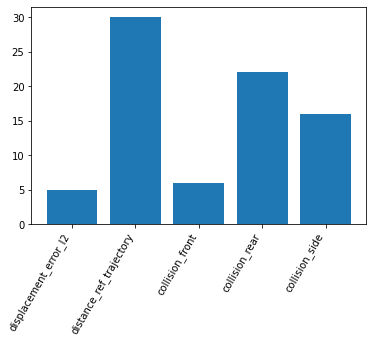

In [16]:
from src.validate.validator import CLEValidator
import matplotlib.pyplot as plt
import numpy as np

agg = CLEValidator(sim_outs)
fields = ["metric", "value"]
table = PrettyTable(field_names=fields)

values = []
names = []

for metric_name in agg:
    table.add_row([metric_name, agg[metric_name].item()])
    values.append(agg[metric_name].item())
    names.append(metric_name)

print(table)

plt.bar(np.arange(len(names)), values)
plt.xticks(np.arange(len(names)), names, rotation=60, ha='right')
plt.show()